In [3]:
import os
import numpy as np
import pandas as pd
import cv2 as cv 
import matplotlib.pyplot as plt

import pytesseract
pytesseract.pytesseract.tesseract_cmd = '/opt/homebrew/bin/tesseract'

## 01/04 Text Recognition
**Summary of Previous Work Done**     
    
Edits to `notebooks/2022-1221_NT_Image-Preprocessing.ipynb` were corrupted (edge detection and failed scalebar recognition). Tight to "mid" ranges of CANNY proved decent detection on defined images (Test 2).  
     
[**Watershed segmentation (ref)**](https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html)    
proved unuseful (as expected) the Distance Transform's separation between foreground and background ignores the heavy occlusion of particles.     

[**OCR Tesseract Text Extraction (ref)**](https://www.geeksforgeeks.org/text-detection-and-extraction-using-opencv-and-ocr/ )   
Worked well on left hand text, extracted lot number and magnification accurately. Could not identify the 50um scaling on the lower right hand side, despite cropping input image to highlight the region. Kernel sizes [(10,10), (18, 18), (20, 20)] performed similarly, with text extracts still saved in notebook folder.     
   
Bottom right cropping `image[750:, :750]`    

### Thoughts
1. Generalizable function to identify text and scalebar
2. CANNY Edge Detection > Circle Recognition for Demo
3. Found similar existing work (morphology-independent SEM segmentation) published as two students' theses.  
i.  Lab Notebook: Scalebar recognition for Histology [no github, post](https://h-ra.github.io/26-AreaScaleBar/)  
ii. Thermal spray (occluded circles) segmentation [paper](https://onlinelibrary.wiley.com/doi/pdf/10.1002/qre.2689)    
iii. Lost thesis...

### Image Loading

How to generalize root to be parent of git repo?

In [17]:
data_root = "/Users/nicolelrtin/vision-test/data/source"
internal = data_root + '/internal/'
# take 10 images
file_names = os.listdir(internal)
image = []
for name in file_names: image += [cv.imread(internal + name)]

sample = image[2].copy()

### Helper Functions
Image Display/Saving

In [18]:
# preview image, missing save image functionality
def preview(img, savename = 'preview_image'):
    cv.imshow(savename, img)
    k = cv.waitKey(0)
    
    if k == ord('s'):
        cv.imwrite(savename + '.png', img)

## Text Recognition+Extraction

01/04: OCR recognizes left-side text on plain image. Crop image to read scalebar text

In [19]:
# -- Finding Optimal Edge Detection
# wide = cv.Canny(image[1], 10, 200)
mid = cv.Canny(sample, 30, 150)
# tight = cv.Canny(image[1], 50, 150)

def crop_to_text(img):
    return img[750:, :]

def dilate(img):
    kernel = np.ones((5,5), np.uint8)
    return cv.dilate(image, kernel, iterations= 1)

def canny(img, thresh_a = 30, thresh_b = 150):
    return cv.Canny(img, thresh_a, thresh_b)

def box_image_text(image, name = 'bounded_text'):
    img = image.copy()
    h, w, c = img.shape
    boxes = pytesseract.image_to_boxes(img) 
    for b in boxes.splitlines():
        b = b.split(' ')
        img = cv.rectangle(img, (int(b[1]), h - int(b[2])), 
              (int(b[3]), h - int(b[4])), (0, 0, 255), 2)

    cv.imshow(name, img)
    cv.waitKey(0)

In [20]:
base_image = sample.copy()
cropped_img = base_image[750:, :]

# miscellaneous preprocessing
blur_img = cv.GaussianBlur(cropped_img, (3,3), 0)
canny_img = canny(blur_img)
# dilated_img = dilate(canny_img)

In [21]:
box_image_text(base_image, 'box_base_img')
pytesseract.image_to_string(base_image)

''

In [9]:
cropped = base_image[900:, 950:]
box_image_text(cropped, 'cropped')
pytesseract.image_to_string(cropped)

'50.0um\n'

## Circle Recognition

In [22]:
base_image = sample.copy()

blur_img = cv.GaussianBlur(base_image, (3,3), 0)
canny_img = cv.Canny(blur_img, 30, 150)
# preview(canny_img, 'with blur')

Hough Circles

In [23]:
# circled_image = base_image.copy()

# # detect circles in image
# circles = cv.HoughCircles(canny_img, cv.HOUGH_GRADIENT, 1.2, 300)

# if circles is not None:
#     # convert (x,y) coordinates and radius to int
#     circles = np.round(circles[0,:]).astype(int)

#     for (x, y, r) in circles:
#         cv.circle(circled_image, (x, y), r, (0, 255, 0), 4)
#         cv.rectangle(circled_image, (x-2, y-2), (x+2, y+2), (0, 128, 255), -1)
    
#     preview(circled_image, 'hough_circled_image')

Blob Detector

In [24]:
# blob_image = canny_img.copy()

# params = cv.SimpleBlobDetector_Params()

# # params.filterByCircularity = True
# # params.minCircularity = 0.8

# detector = cv.SimpleBlobDetector_create(params)
# keypoints = detector.detect(blob_image)

# # draw circles onto image
# blank = np.zeros((1,1))
# blobs = cv.drawKeypoints(blob_image, keypoints, blank, (0, 0, 255),
#         cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# n_blobs = len(keypoints)
# title = 'Num. Circular Blobs: ' + str(n_blobs)
# print(title)

# preview(blobs, 'Filtering Circular Blobs Only')

sklearn.image hough transform

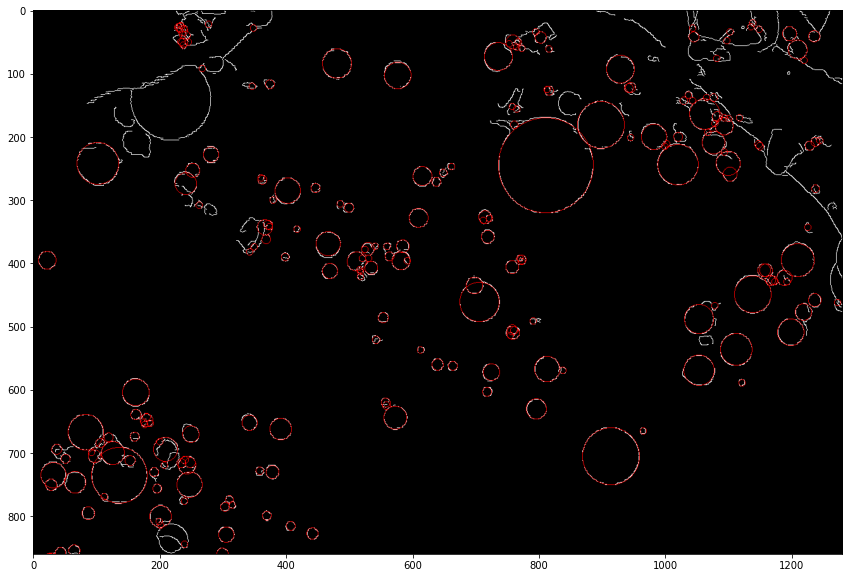

In [29]:
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import peak_local_max, canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from skimage import color

base_image2 = canny_img[:860, :].copy()

# Detect wide range of radii
hough_radii = np.arange(5, 300)
hough_res = hough_circle(canny_img, hough_radii)

# Select the most prominent 300 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                        min_xdistance=2, min_ydistance=2, total_num_peaks=400)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 10))
base_image2 = color.gray2rgb(base_image2)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,shape=base_image2.shape)
    base_image2[circy, circx] = (250, 0 ,0)

ax.imshow(base_image2, cmap=plt.cm.gray)

In [26]:
preview(base_image2, 'hough_cicles')

## Scale Recognition

Use Probablistic Hough Line Transform to find (x,y) of first and last line

In [27]:
scale_img = base_image[905:, 700:].copy()
# scale_img = cv.cvtColor(scale_img, cv.COLOR_RGB2GRAY)
scale_edged_img = cv.Canny(cv.GaussianBlur(scale_img, (5,5), 0), 30, 50)
# scale_edged_img = cv.Canny(scale_img, 30, 150)

lines = cv.HoughLinesP(image=scale_edged_img,rho=1,
                        theta=np.pi/180, threshold=30,
                        lines=np.array([]))

lines_list = []
for points in lines:
    # Extracted points nested in the list
    x1,y1,x2,y2 = points[0]
    # Draw the lines joining the points
    cv.line(scale_img,(x1,y1),(x2,y2),(0,0,255),2)
    # Maintain a simples lookup list for points
    lines_list.append([(x1,y1),(x2,y2)])

preview(scale_img, 'houghlinesp')

In [28]:
scale_img = base_image[905:, 700:].copy()
scale_edged_img = cv.Canny(scale_img, 30, 50)
preview(scale_edged_img)